# Discounted random chain, 100 episodes
gamma = 0.6

In [6]:
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the different CSVs as DataFrames

In [35]:
in_parent_dir = '/Users/anthony/Playground/tensorboard_logs/10-03/discounted_100epis_gamma6'
exp_csv_regex = 'exp*/progress.csv'

exp_csv_pathlist = glob.glob(os.path.join(in_parent_dir, exp_csv_regex))
exp_csv_pathlist

['/Users/anthony/Playground/tensorboard_logs/10-03/discounted_100epis_gamma6/exp18_STrace_gamma6_100epis/progress.csv',
 '/Users/anthony/Playground/tensorboard_logs/10-03/discounted_100epis_gamma6/exp20_SR_gamma6_100epis/progress.csv']

#### Read all CSVs into a single dataframe

In [36]:
# Read all
exp_df_lists = []
for csv_path in exp_csv_pathlist:
    print('Reading:', csv_path)
    cur_df = pd.read_csv(csv_path, sep='\|\|')
    
    cur_df = cur_df.drop(cur_df.columns[0], axis=1)
    
    exp_df_lists.append(cur_df)

# Concat
data_df = pd.concat(exp_df_lists)

print(len(data_df))
data_df[0:5]

Reading: /Users/anthony/Playground/tensorboard_logs/10-03/discounted_100epis_gamma6/exp18_STrace_gamma6_100epis/progress.csv


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


Reading: /Users/anthony/Playground/tensorboard_logs/10-03/discounted_100epis_gamma6/exp20_SR_gamma6_100epis/progress.csv
155000


,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
0,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,0,30,1.0,0.500054,0.499936,0.499979,0.473700,None,1.161837
1,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,1,114,1.0,0.500117,0.499553,0.499853,0.473564,None,1.161765
2,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,2,232,1.0,0.500140,0.498728,0.499576,0.473272,None,1.161452
3,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,3,22,1.0,0.500203,0.498707,0.499564,0.473257,None,1.161450
4,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,4,102,1.0,0.500270,0.498444,0.499454,0.473142,None,1.161390


## Get runs form a specific episode

In [37]:
epis_idx_filter = 90

epis_data_df = data_df[data_df['episode_idx']==epis_idx_filter]

print(len(epis_data_df))
epis_data_df[0:3]

1550


,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
90,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,90,22,1.0,0.502287,0.478709,0.489132,0.462210,None,1.152817
190,100,19,STraceAgent,2,0.6,0.0001,1.0,0.05,False,90,184,1.0,0.502293,0.479535,0.489863,0.462967,None,1.155489
290,100,19,STraceAgent,4,0.6,0.0001,1.0,0.05,False,90,92,0.0,0.501779,0.477241,0.487981,0.461068,None,1.153140


#### Get different sub-DataFrames depending on the run

In [38]:
from itertools import product

indep_cols = ['agentCls_name', 'use_true_s_mat']

# Get all the different combinations of independent cols
indep_col_val_list = []
for indep_col in indep_cols:
    indep_col_val_list.append( list(set(epis_data_df[indep_col].values)) )
indep_col_val_cartesian_prod = product(*indep_col_val_list)

# Filter for sub-dataframes, one for each combination
indep_col_df_dict = {}

for val_tup in indep_col_val_cartesian_prod:    
    # Filter
    cur_df = epis_data_df.copy(deep=True)
    for i in range(len(indep_cols)):
        cur_indep_col = indep_cols[i]
        cur_df = cur_df[cur_df[cur_indep_col] == val_tup[i]]
    
    # Save
    if len(cur_df) > 0:
        cur_comb_name = '_'.join([str(e) for e in list(val_tup)])
        indep_col_df_dict[cur_comb_name] = cur_df
    
# Print
for k in indep_col_df_dict:
    print(k, len(indep_col_df_dict[k]))

STraceAgent_False 850
SRAgent_False 700


### Plot RMSE

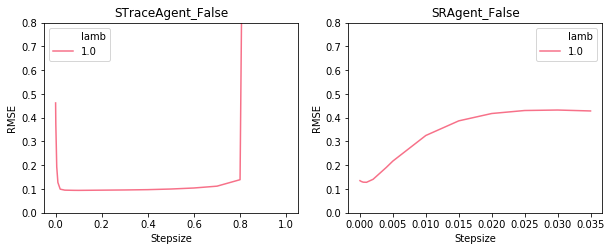

In [39]:
# ==
# Specify plots
plot_x = 'lr'
plot_y = 'v_vec_rmse'
plot_hue = 'lamb'
plot_ci = None  # Estimator, [None, 'sd']


# ==
# Plot

plt.figure(figsize=(10, 3.5))

# Generate subplots
total_n_plots = len(indep_col_df_dict)
n_plot_counter = 1
for k in indep_col_df_dict:
    # Current
    cur_df = indep_col_df_dict[k]
    
    # Generate palette
    n_hues = len(set(cur_df[plot_hue].values))
    c_palette = sns.color_palette("husl", n_hues)
    
    # Plot
    plt.subplot(1, total_n_plots, n_plot_counter)
    sns.lineplot(x=plot_x, y=plot_y, hue=plot_hue, 
                 ci=plot_ci, 
                 palette = c_palette,
                 data=cur_df)
    
    
    plt.ylim([0, 0.8])
    plt.ylabel('RMSE')
    plt.xlabel('Stepsize')
    plt.title(str(k))
    
    # Counter var
    n_plot_counter += 1
    


## Plot training progress

In [17]:
epis_data_df[0:4]

,num_episodes,n_states,agentCls_name,seed,gamma,lr,lamb,s_subsample_prop,use_true_s_mat,episode_idx,total_steps,cumulative_reward,v_vec_max,v_vec_min,v_vec_avg,v_vec_rmse,s_mat_norm,s_mat_rmse
90,100,19,STraceAgent,0,0.6,0.0001,1.0,0.05,False,90,22,1.0,0.502287,0.478709,0.489132,0.462210,None,1.152817
190,100,19,STraceAgent,2,0.6,0.0001,1.0,0.05,False,90,184,1.0,0.502293,0.479535,0.489863,0.462967,None,1.155489
290,100,19,STraceAgent,4,0.6,0.0001,1.0,0.05,False,90,92,0.0,0.501779,0.477241,0.487981,0.461068,None,1.153140
390,100,19,STraceAgent,6,0.6,0.0001,1.0,0.05,False,90,52,1.0,0.502324,0.477012,0.488560,0.461632,None,1.153050


In [18]:
set(cur_df['lr'].values)

{5e-06,
 5e-05,
 0.00025,
 0.0005,
 0.001,
 0.002,
 0.004,
 0.005,
 0.01,
 0.015,
 0.02,
 0.025,
 0.03,
 0.035}

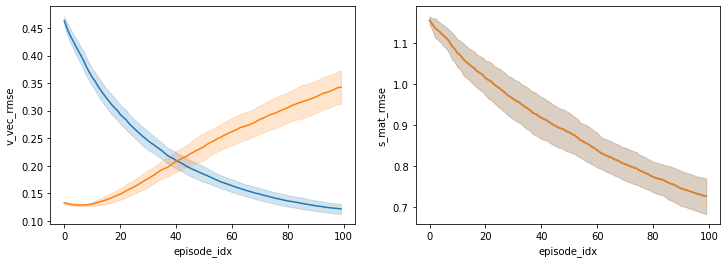

In [50]:
# ==
# Filter for dataframe
cur_df = data_df.copy(deep=True)

# Make the SR agent dataframe
cur_df1 = cur_df[cur_df['agentCls_name']=='SRAgent']
cur_df1 = cur_df1[cur_df1['lr'] == 0.01]

# Make the STrace agent dataframe
cur_df2 = cur_df[cur_df['agentCls_name']=='STraceAgent']
cur_df2 = cur_df2[cur_df2['lamb'] == 1.0]
cur_df2 = cur_df2[cur_df2['lr'] == 0.01]


# ==
# Generate plots

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.lineplot(x='episode_idx', y='v_vec_rmse', ci='sd', data=cur_df2)
sns.lineplot(x='episode_idx', y='v_vec_rmse', ci='sd', data=cur_df1)


plt.subplot(1,2,2)
sns.lineplot(x='episode_idx', y='s_mat_rmse', ci='sd', data=cur_df2)
sns.lineplot(x='episode_idx', y='s_mat_rmse', ci='sd', data=cur_df1)



plt.show()


In [ ]:
epis_data_df[epis_data_df['use_true_s_mat'].isin([False])]